In [1]:
%load_ext jupyternotify

import numpy as np
import matplotlib
#allow for latex markup in matplotlib figures
matplotlib.rcParams['text.usetex'] = False
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap


#Import a few utility functions...
import sys  
from pathlib import Path
sys.path.insert(0, "../comm_channel")
sys.path.insert(0, "../polling_systems")
sys.path.insert(0, "../geometry")
sys.path.insert(0, "../utils")

#So we can import my local libs
import CommChannel as CC
import qos
import pointcloud as PC
import TSPN
import PollingSystem as PS
import MarkovianRP as MRP
import dtr
import motion
import shot_solvers as SHOT

import sim_template as sim
from importlib import reload 

<IPython.core.display.Javascript object>

In [2]:
#setup quality of service requirements using reasonable values
F5GHz, F2_4GHz = 5, 2.4 #typical wifi frequencies are 2.4, 5, and sometiems 6 GHz
MOBILE_TX_POWER = qos.Pwr(20)#100-200mW (20-23 dBm) pretty typical, with 1W (30dBm) the absolute maximum
print(MOBILE_TX_POWER)
r = 8#any of 2, 4, 6, or 8
rx_noise = qos.Pwr(-85)#based on Yan and MostofiTWC13 #1e-10#
print(rx_noise)
BER = 1e-6
GAMMA_TH = qos.QoSReq(BER, r, rx_noise).thresholdChannelGain(MOBILE_TX_POWER)
print(GAMMA_TH)
print('SNR Threshold: %d'%(GAMMA_TH+MOBILE_TX_POWER.dBm - rx_noise.dBm))

20.000000 dBm	-10.000000 dBW	100.000000 mW	0.100000 W
-85.000000 dBm	-115.000000 dBW	0.000000 mW	0.000000 W
-71.8297512825111
SNR Threshold: 33


In [3]:
#Setup the communication environment:

#For now, use same channel params
nPL = 5.2
kPL = -20

decorrSH = 2.09  
alpha = 16
sigmaSH = np.sqrt(alpha)
psdAtFC = 30

lam = 0.125
kRic = 10
decorrMP = 0.4*lam         
corrMP = 1
#sigmaMP = 3
sigmaMP = 1.5


#12 remote stations
l = 11
qBase = np.array([[2,11],[20,9],
                 [27,6],[28,23],
                 [10,22],[11,39],
                 [30, 11],[48, 8],
                 [20, 30],[37, 35],
                 [32, 27],[48, 19]])

sub_regions = [[25,0,16,0],
               [35, 22, 23, 6],
               [20,0, 40, 17],
               [50, 25, 18, 3],
               [40, 17, 39, 21],
               [50, 30, 32, 14]]


x_max = 50
x_min = 0
y_max = 50
y_min = 0
region = [x_max, x_min, y_max, y_min]


cps = [CC.ChannelParams(qBase[i], nPL, kPL, sigmaSH, decorrSH, decorrMP, lam,
                      kRic, corrMP, psdAtFC, sigmaMP) for i in range(len(qBase))]



#res = 2/decorrMP
res = 10
n = 6
p_th = 0.5

#Polling System Setup
bandwidth = 2#leave bandwidth in MHz*1000000#give ourselfes 2MHz of BW
beta = 1/(r*bandwidth)
print(beta)
els = np.array([0.01/beta, 0.2/beta, 0.01/beta, 0.2/beta, 0.01/beta, 0.2/beta])
traffic = sum(els)*beta
print(els)
print(traffic)

0.0625
[0.16 3.2  0.16 3.2  0.16 3.2 ]
0.6300000000000001


In [4]:
reload(sim)
ccs, cfs, true_joint_con_fields, tjcps = sim.create_channels(cps, region, res, GAMMA_TH, sub_regions)

Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing genera

In [5]:
reload(sim)
pcs, pfs, pjcps, prob_pred_con = sim.predict_channels(res, ccs, true_joint_con_fields, GAMMA_TH, p_th=p_th)
trismall_pcs = pcs

print(prob_pred_con)

Drawing 400 samples from Channel 1
Completed PredictedChannel 1
Drawing 400 samples from Channel 2
Completed PredictedChannel 2
Drawing 221 samples from Channel 3
Completed PredictedChannel 3
Drawing 221 samples from Channel 4
Completed PredictedChannel 4
Drawing 460 samples from Channel 5
Completed PredictedChannel 5
Drawing 460 samples from Channel 6
Completed PredictedChannel 6
Drawing 375 samples from Channel 7
Completed PredictedChannel 7
Drawing 375 samples from Channel 8
Completed PredictedChannel 8
Drawing 414 samples from Channel 9
Completed PredictedChannel 9
Drawing 414 samples from Channel 10
Completed PredictedChannel 10
Drawing 360 samples from Channel 11
Completed PredictedChannel 11
Drawing 360 samples from Channel 12
Completed PredictedChannel 12
[0.8047454275827979, 0.745253164556962, 0.7595450852965069, 0.7593220338983051, 0.8275862068965517, 0.8145695364238411]


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


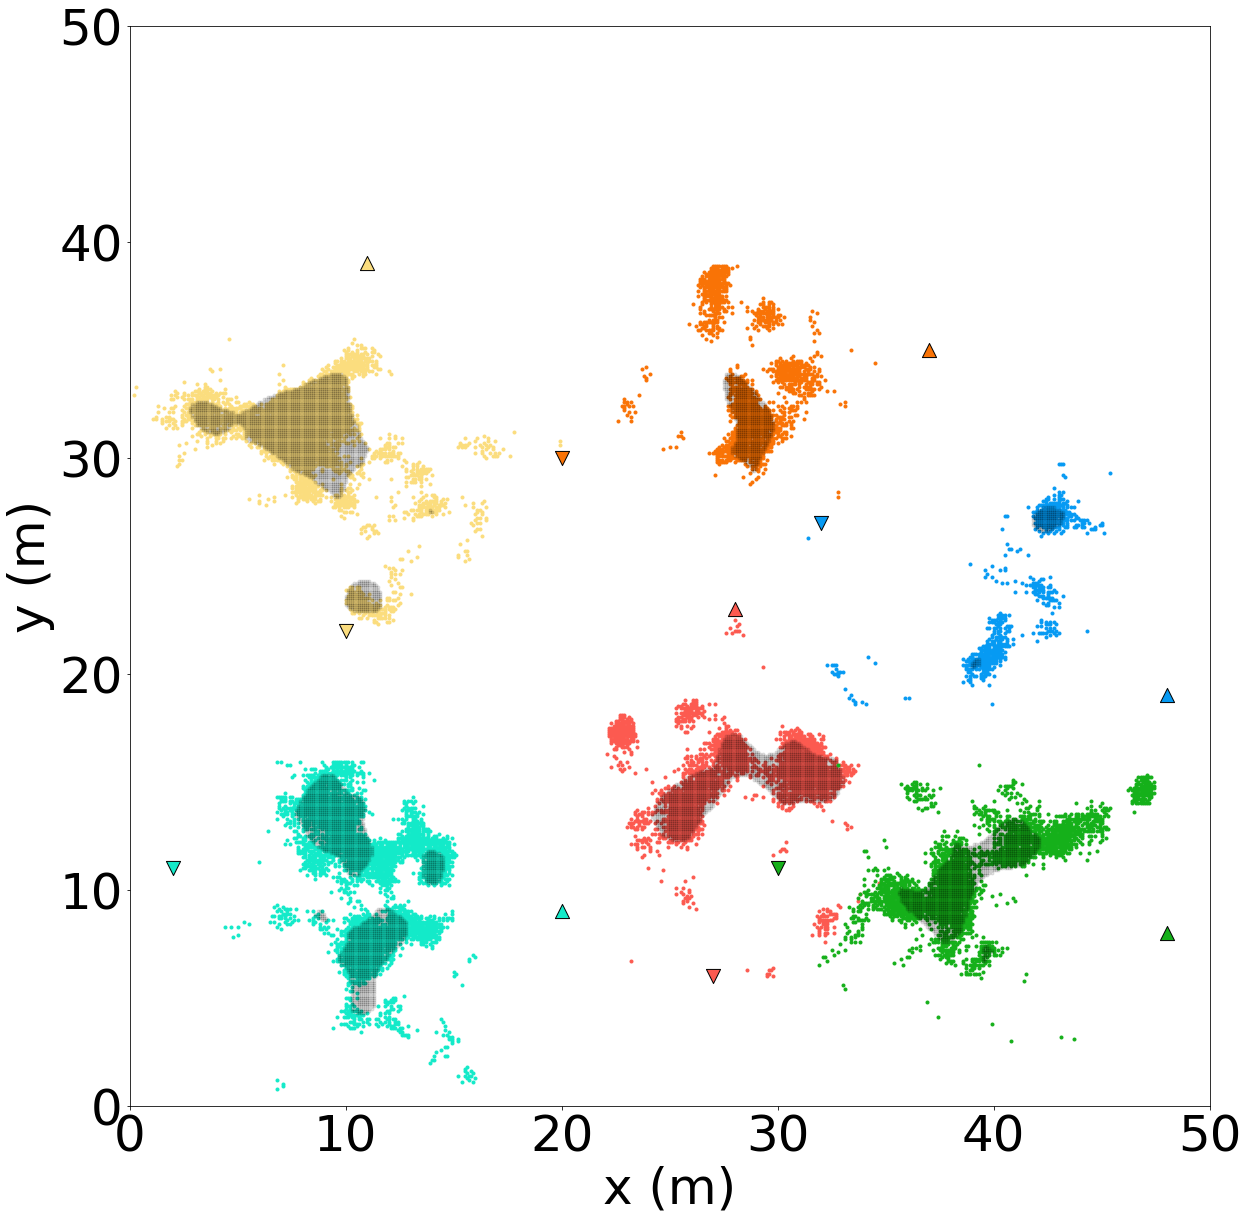

In [6]:
reload(sim)
sim.plotCFwithOverlay(n, tjcps, pjcps, qBase, region)
plt.gca().invert_yaxis()
plt.show()

In [7]:
#setup the delay-tolerant relay system
reload(dtr)
dt_sys = dtr.DTR(pcs, region, els, beta, th=GAMMA_TH, p_th = p_th)

Extracted edges...
Polygons constructed, looking for holes...
Constructed 4 possibly non-convex polygons
13 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
10 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
Info: Reduced Poly only contains two points. Reduction ignored
Poly: ([13.9 27.5])  ([14.  27.5])  ([13.9 27.6]) Is Interior: False
10 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
8 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
3 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
3 total subregions


Total of 60 Permutations to Try
Working on Permutation (0, 1, 2, 3, 4, 5)
Optimal Solution Improved to 113.24
Working on Permutation (0, 1, 2, 3, 5, 4)
Optimal Solution Improved to 99.42
Working on Permutation (0, 1, 2, 4, 3, 5)
Optimal Solution Improved to 95.59
Working on Permutation (0, 1, 2, 4, 5, 3)
Optimal Solution Improved to 87.81
Working on Permutation (0, 1, 2, 5, 3, 4)
skiping based on lower bound
Working on Permutation (0, 1, 2, 5, 4, 3)
skiping based on lower bound
Working on Permutation (0, 1, 3, 2, 4, 5)
skiping based on lower bound
Working on Permutation (0, 1, 3, 2, 5, 4)
skiping based on lower bound
Working on Permutation (0, 1, 3, 4, 2, 5)
skiping based on lower bound
Working on Permutation (0, 1, 3, 4, 5, 2)
Working on Permutation (0, 1, 3, 5, 2, 4)
Working on Permutation (0, 1, 3, 5, 4, 2)
Optimal Solution Improved to 75.88
Working on Permutation (0, 1, 4, 2, 3, 5)
skiping based on lower bound
Working on Permutation (0, 1, 4, 2, 5, 3)
skiping based on lower bound
W

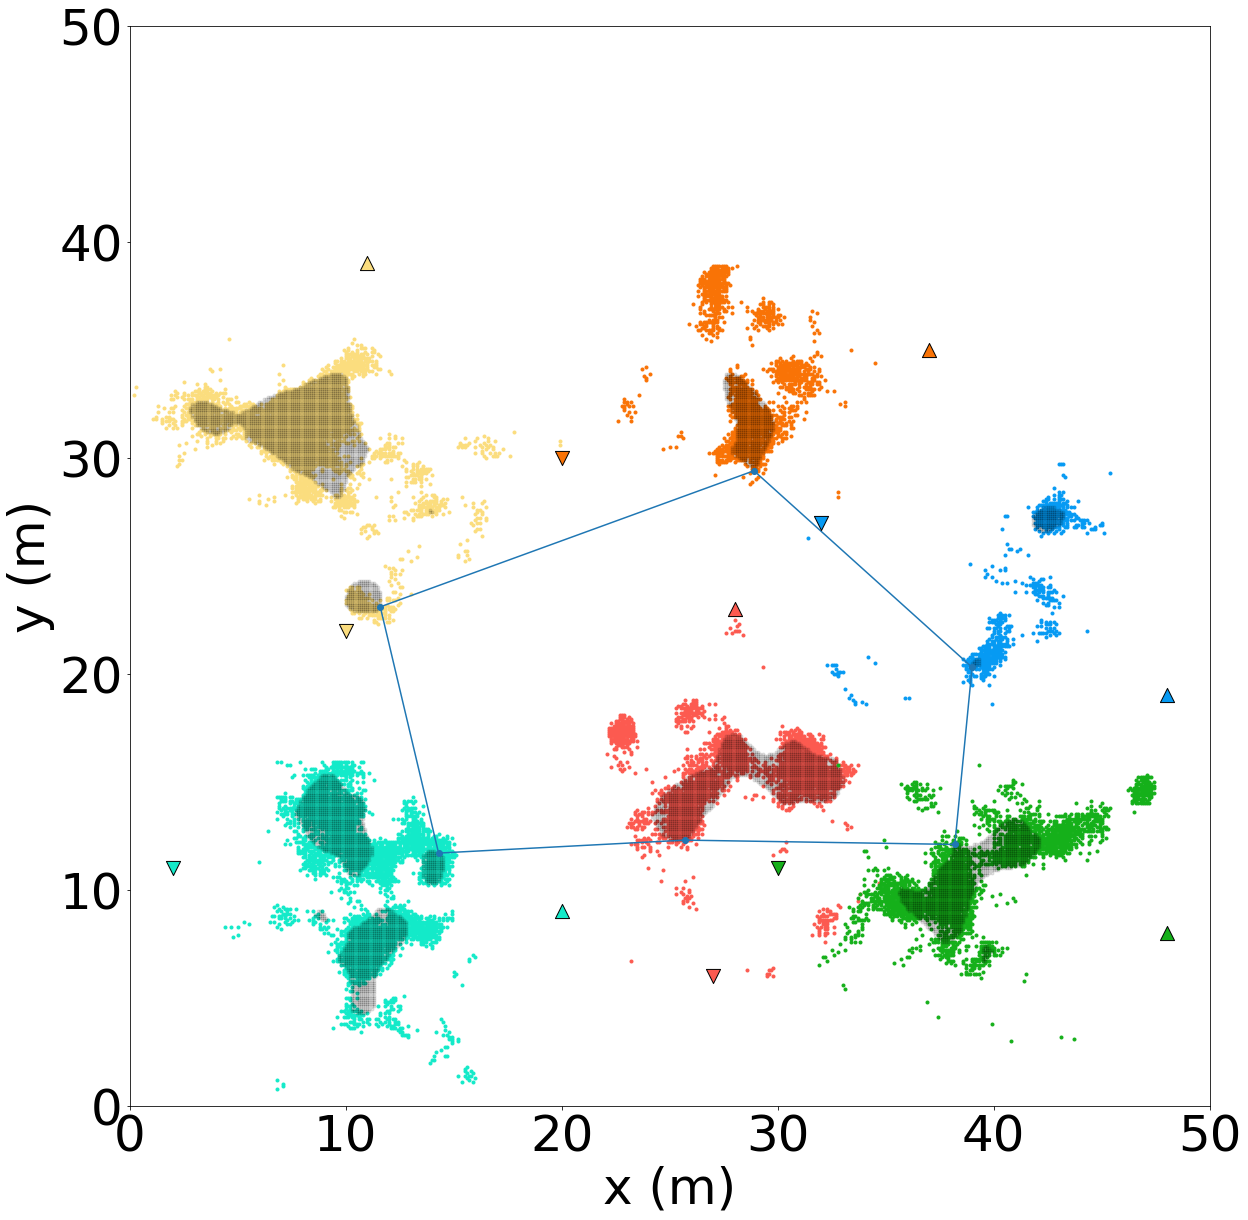

In [8]:
reload(sim)
regions = dt_sys.cregions
tspn_min, tspn_argmin = TSPN.TSPN_BF(regions)
x=tspn_argmin[0]

TSPNP={'X':x, 'SEQ':tspn_argmin[1]}

order = list(tspn_argmin[1])
order.append(0)#complete the loop
sim.plotCFwithOverlay(n, tjcps, pjcps, qBase, region)
plt.plot(x[order,0], x[order,1], zorder=100)
plt.scatter(x[:,0], x[:,1], zorder = 100)
plt.gca().invert_yaxis()
plt.show()

In [14]:
reload(sim)
reload(PS)
v = 1
ps = dt_sys.ps
#ratios OK, let's just reduce the overall traffic
els = np.array([0.01/beta, 0.2/beta, 0.01/beta, 0.2/beta, 0.01/beta, 0.2/beta])*0.7
ps.Ls = els

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    'font.size': 35})

print("Finding AORP")
AORP = sim.calc_AORP(dt_sys, v)
print("Found AORP")
pi = AORP['pi']
S = dtr.XtoS(AORP['X'])
S_cy = dtr.XtoS(TSPNP['X'])
S_cyv = np.zeros(n)
seq = TSPNP['SEQ']
for i in range(n):
    S_cyv[i] = S_cy[seq[i], seq[(i+1)%n]]

#S_i = S @ pi
W_rnd = ps._calc_avg_wait_random(S, pi)
W_cy = ps._calc_avg_wait_cyclic(S_cyv)

#print(S)
P_tilde, pi_tilde = sim.pi_to_P(pi)
print(P_tilde)
S_i = np.diag(P_tilde@S)
print(els)
print(pi)
print(pi_tilde)
print(S_i)
print(W_rnd)
print(W_cy)

Finding AORP
Found AORP
[[0.         0.39493559 0.02286364 0.2937268  0.03207014 0.25640384]
 [0.03974176 0.         0.03628539 0.46615463 0.05089643 0.40692179]
 [0.0249871  0.39407733 0.         0.29308848 0.03200045 0.25584663]
 [0.03424178 0.54003506 0.03126375 0.         0.04385272 0.35060669]
 [0.02521877 0.39773109 0.02302548 0.2958059  0.         0.25821876]
 [0.0325791  0.51381242 0.02974566 0.38213947 0.04172335 0.        ]]
[0.112 2.24  0.112 2.24  0.112 2.24 ]
[0.02442976 0.38528741 0.02230508 0.28655112 0.03128667 0.25013995]
[0.03381525 0.33604057 0.03094155 0.29006796 0.04300208 0.26613259]
[22.16981125  8.37953308 24.92816776  8.64793309 16.23888361  9.48520974]
60.98969553252456
58.84610237265896


In [18]:
reload(sim)
hrs = 2
mins = 0
seconds = 0
print('Velocity = %f'%(v))
motion_power = motion.LinearMotionPower(7.2, 0.29, v)
sim.run_sims(dt_sys.ps, AORP, TSPNP, hrs, mins, seconds, motion_power, MOBILE_TX_POWER.W, v)
print('done')

Velocity = 1.000000
Theotretical MB serviced: 50803.2
Theoretical Energy Consumption (J): 30463.272000000004
	Th. WT	WT	E (J)	MBS	MBR
AORP	60.99	62.65	30801.35	50248.00	501.00
Tab	---	43.71	30698.96	50293.00	216.00
TSPN	---	57.93	30778.09	50263.00	312.00
done


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

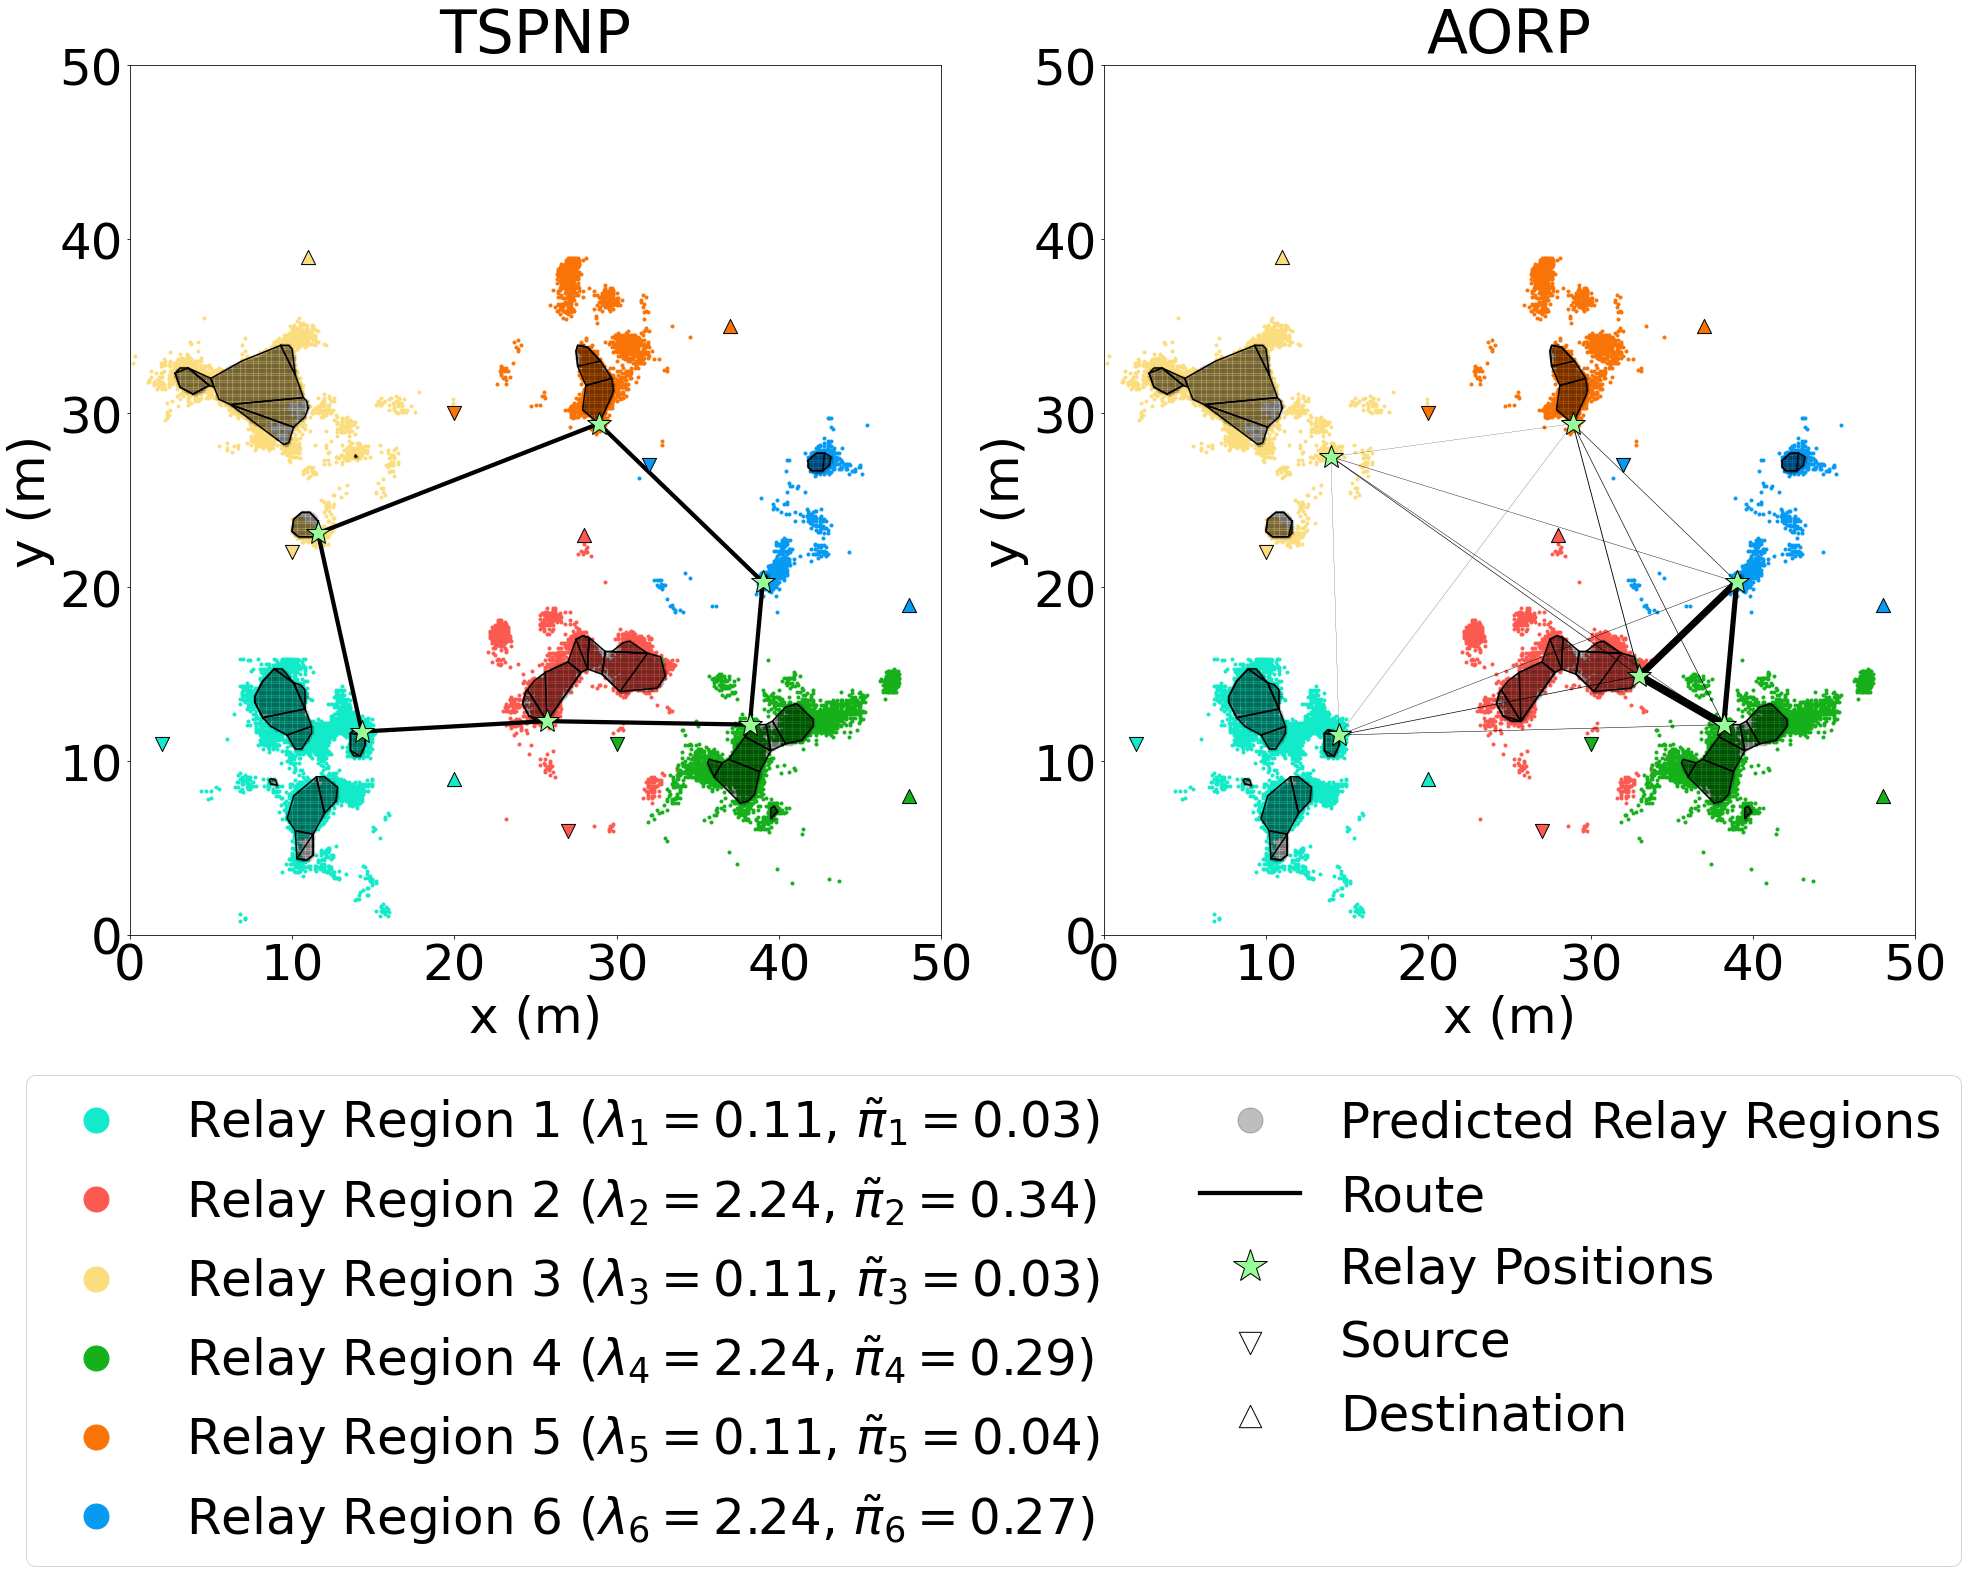

In [17]:
reload(sim)
sim.plot_AORP_W_TSPN(dt_sys, AORP, TSPNP, tjcps, pjcps, qBase, region, els, AORP['pi'])

plt.savefig("six_spread_TSPNP_v_AORP.png", format='png', bbox_inches='tight')
plt.savefig("six_spread_TSPNP_v_AORP.eps", format='eps', bbox_inches='tight')